# Imports

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [99]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [100]:
import warnings
warnings.filterwarnings("ignore")

# Data preparation

In [101]:
df = pd.read_csv("data/train.csv")
df

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,19214,749,757,143210,143219,17,4,4,2193,122,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,19215,723,735,2488529,2488541,231,17,26,27135,104,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,19216,6,31,1578055,1578129,780,114,98,71112,41,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,19217,9,18,1713172,1713184,126,13,26,14808,88,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


In [102]:
df.drop("id", axis=1, inplace=True)

In [103]:
sns.set_theme(style="dark", palette="magma")
# sns.set_palette("dark")

In [104]:
def draw_heatmap(data, mask=None):
    plt.figure(figsize=(12, 12))
    sns.heatmap(data.corr(), mask=mask)
    plt.show()

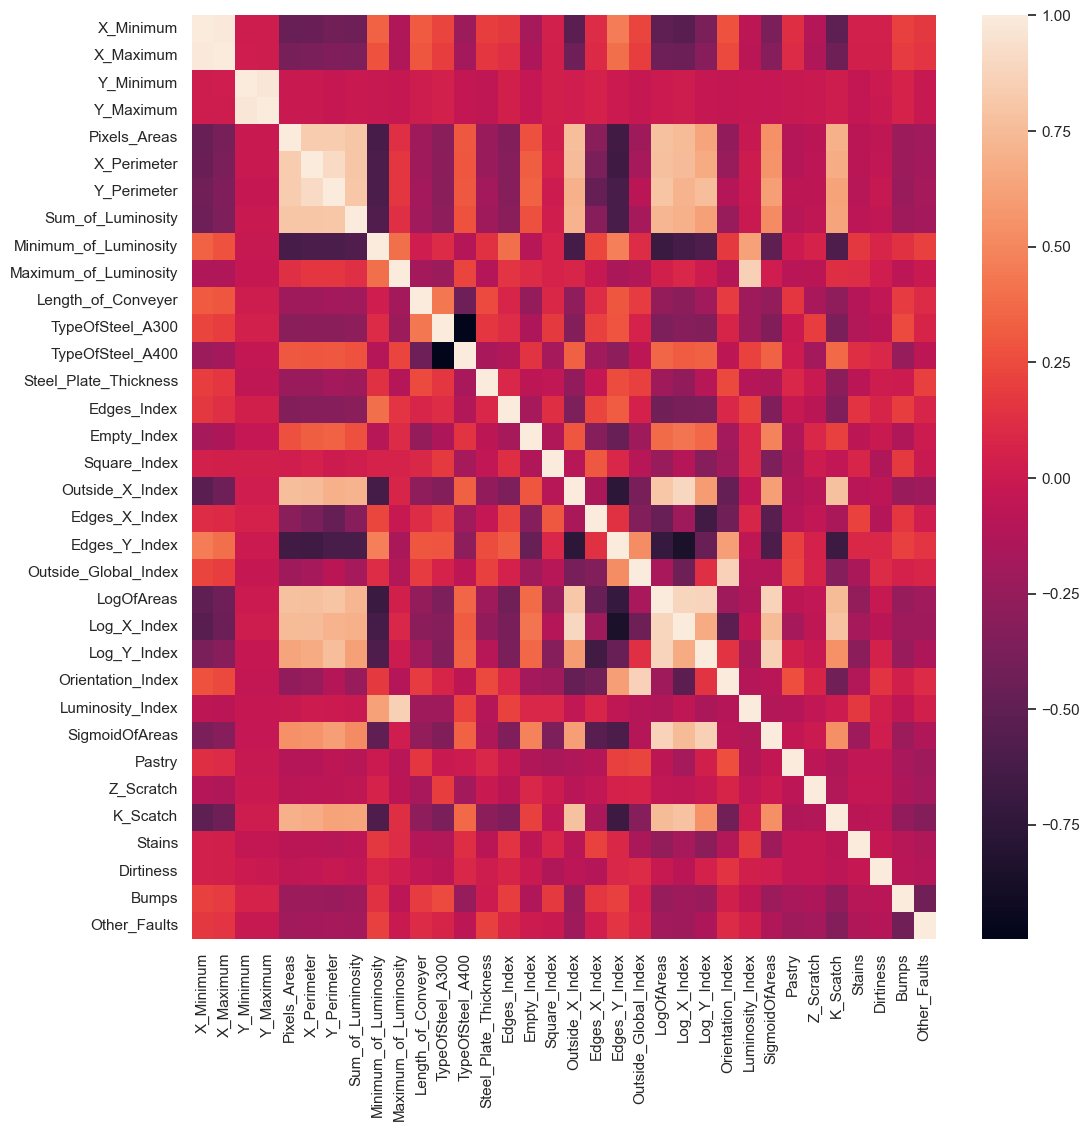

In [105]:
draw_heatmap(df)

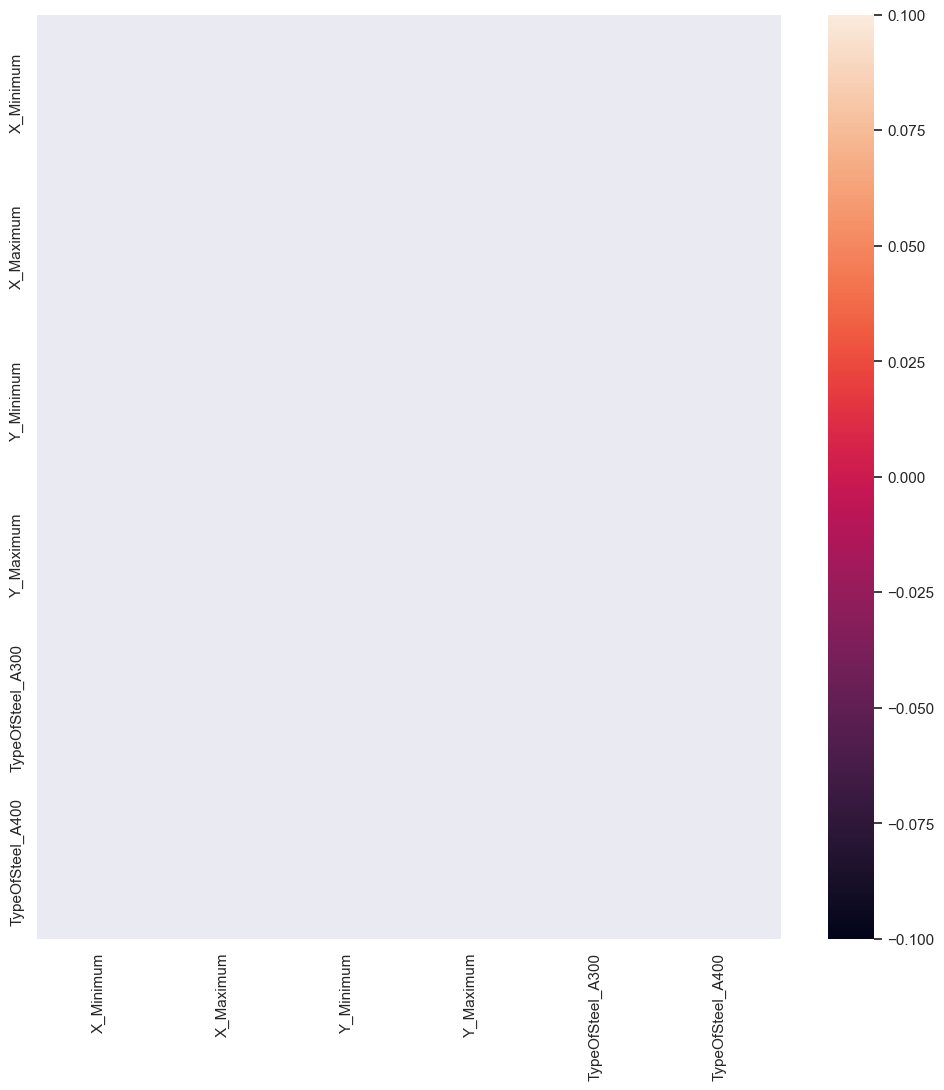

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,TypeOfSteel_A300,TypeOfSteel_A400
X_Minimum,NaN,0.989767,NaN,NaN,NaN,NaN
X_Maximum,0.989767,NaN,NaN,NaN,NaN,NaN
Y_Minimum,NaN,NaN,NaN,0.969552,NaN,NaN
Y_Maximum,NaN,NaN,0.969552,NaN,NaN,NaN
TypeOfSteel_A300,NaN,NaN,NaN,NaN,NaN,-0.997732
TypeOfSteel_A400,NaN,NaN,NaN,NaN,-0.997732,NaN


In [ ]:
res = df.corr().where(lambda x: (abs(x) > 0.95) & (abs(x) != 1.0)).dropna(axis=1, how='all').dropna(axis=0, how='all').fillna(0) # Не знаю, почему без fillna оно работает так плохо, но тем не менее
draw_heatmap(res)
res
# df.corr().any(lambda x: abs(x) > 0.8 || abs(x) != 1.0)
# df.loc[lambda x: abs(x)]
# df.loc[(df['Salary_in_1000']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]

In [107]:
df.drop(["TypeOfSteel_A400", "X_Minimum", "Y_Minimum"], axis=1, inplace=True)

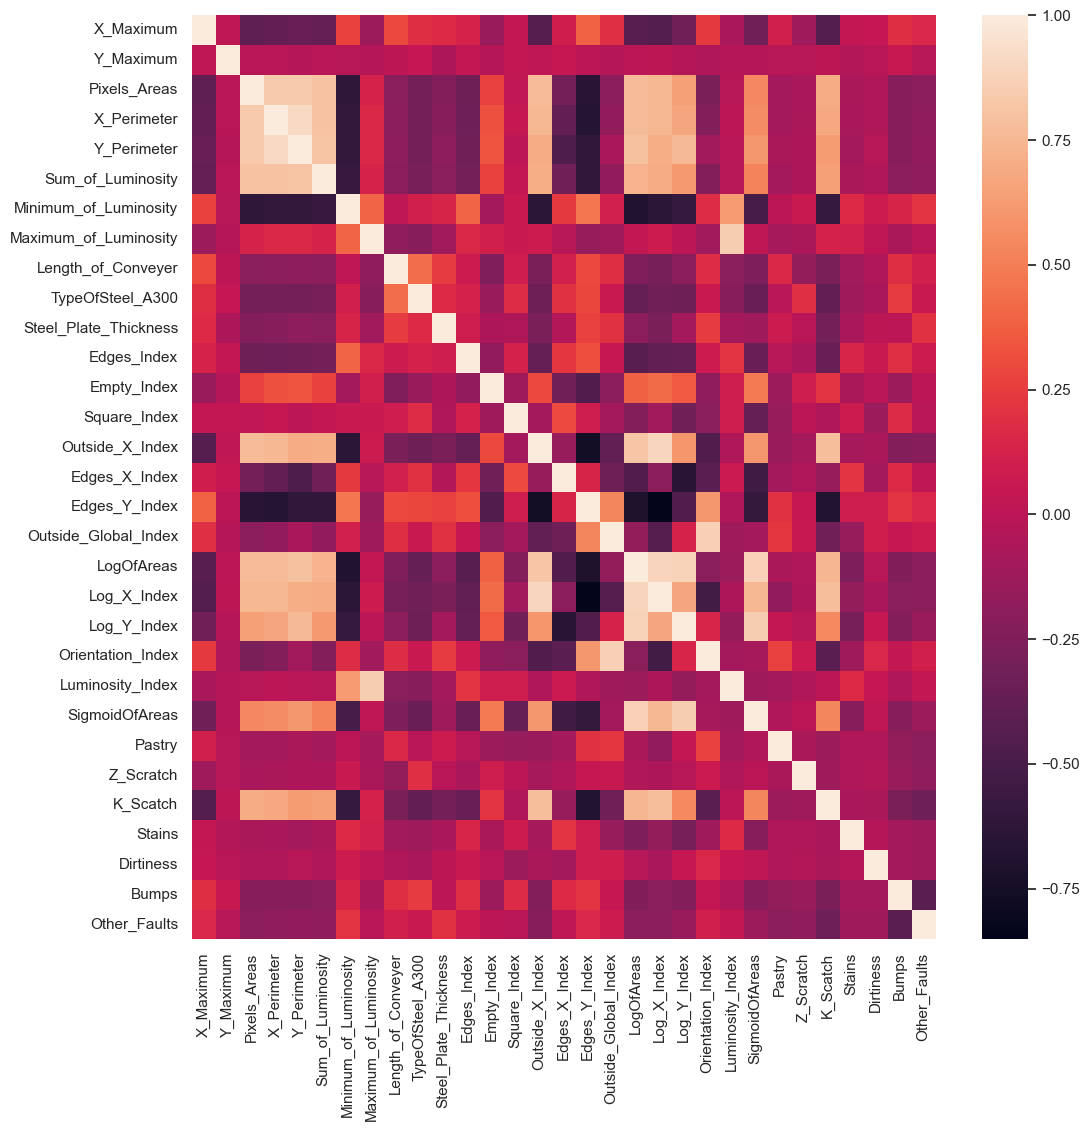

In [108]:
draw_heatmap(df)

In [109]:
target_columns = [
    "Pastry",
    "Z_Scratch",
    "K_Scatch",
    "Stains",
    "Dirtiness",
    "Bumps",
    "Other_Faults",
]
feature_columns = [cl for cl in df.columns if cl not in target_columns ]

In [110]:
feature_columns

['X_Maximum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']

In [111]:
Y = df[target_columns]
X = df[feature_columns]

In [112]:
sc = StandardScaler()

X = sc.fit_transform(X)

In [113]:
Y.value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      1               6540
                                                1      0               4761
                   1         0       0          0      0               3411
1       0          0         0       0          0      0               1465
0       1          0         0       0          0      0               1150
        0          0         0       0          0      0                818
                             1       0          0      0                568
                             0       1          0      0                485
                   1         0       0          0      1                 18
                                                1      0                  2
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42,
    # stratify=Y
)

# Models

## Graph

In [115]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Полносвязная

### Compile

In [116]:
X_train.shape

(15375, 24)

In [117]:
y_train.shape

(15375, 7)

In [131]:
model_fnn = Sequential([
    Dense(24, activation='relu', input_shape=(X_train.shape[1],)),
    # Dropout(0.05),
    Dense(24, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')
])

model_fnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_fnn = model_fnn.fit(
    X_train, y_train,
    epochs=256,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0449 - loss: 0.8211 - val_accuracy: 0.0465 - val_loss: 0.7668
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0507 - loss: 0.7534 - val_accuracy: 0.0498 - val_loss: 0.7148
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0499 - loss: 0.7046 - val_accuracy: 0.0446 - val_loss: 0.6745
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0426 - loss: 0.6649 - val_accuracy: 0.0377 - val_loss: 0.6378
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0444 - loss: 0.6291 - val_accuracy: 0.0719 - val_loss: 0.6008
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0731 - loss: 0.5922 - val_accuracy: 0.1041 - val_loss: 0.5645
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1271 - loss: 0.5577 - val_accuracy: 0.1854 - val_loss: 0.5288
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1829 - loss: 0.5205 - val_accuracy: 0.1896 - 

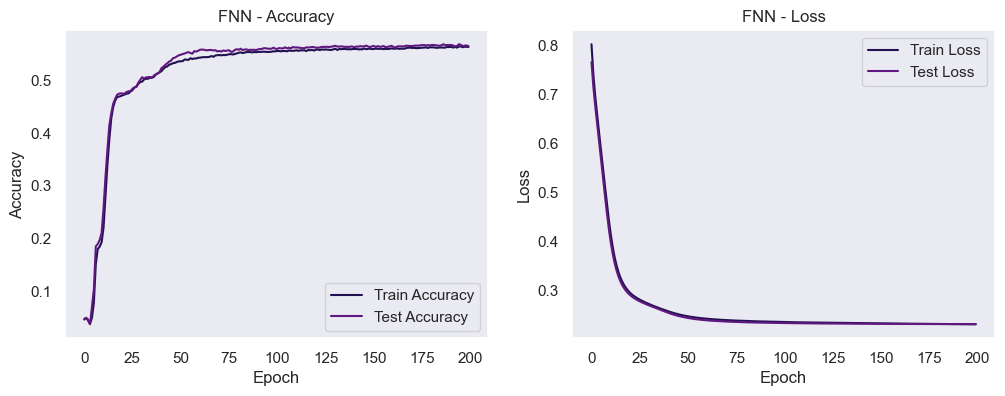

In [133]:
plot_results(history_fnn, "FNN")